# Cross-Entropy of the Hidden States

### Workflow
1. Simulate the transition matrix with 1m step. 
2. Calculate entropy for the states. 

In [1]:
%matplotlib inline

In [4]:
import numpy as np
import scipy as sp
import os
import pickle as pkl
from pandas.core.computation.check import NUMEXPR_INSTALLED
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.append('../..')
from plot_params import*
from helper import*
from data_import import*
pp = PlotParams()
import copy
import matplotlib.image as image
import matplotlib as mpl
from paths import*
paths = paths()

In [5]:
f4_path = paths.f4_path +'/4e9c1cf'

In [6]:
data = pd.read_csv(f4_path + '/NOGTHSH_LEARNING_CURVES_4e9c1cf_8A_learning_curves_pred_prob.csv', index_col=[0])

In [7]:
data.shape

(1565700, 21)

In [8]:
## Filter data
data.rename(columns = {'participant_train': 'participant'}, inplace=True)
data = data.loc[data['trial_type'] != 'Prac']
data = drop_RTs_above_3std_below_180(data)

In [9]:
#data.rename(columns = {'participant': 'participant_train'}, inplace=True)

### Create generative probabilities 

In [10]:
gen_probs_data = get_gen_probs(data)

## Get the pred probs in in the right shape both for iHMM and Markov

In [11]:
iHMM_data = data.loc[data['model'] == 'iHMM'][['participant_test', 'e_train', 'block', 'ini', 'trial', 'y0', 'y1', 'y2', 'y3']]
Markov_data = data.loc[data['model'] == 'Markov'][['participant_test', 'e_train', 'block', 'ini', 'trial', 'y0', 'y1', 'y2', 'y3']]
gen_probs = gen_probs_data[['participant_test', 'e_train', 'block', 'ini', 'trial', 'y0', 'y1', 'y2', 'y3']]

In [12]:
iHMM_data.set_index(['participant_test', 'e_train', 'block', 'ini', 'trial'], inplace = True)
Markov_data.set_index(['participant_test', 'e_train', 'block', 'ini', 'trial'], inplace = True)
gen_probs.set_index(['participant_test', 'e_train', 'block', 'ini', 'trial'], inplace = True)

In [13]:
iHMM_data.columns = pd.MultiIndex.from_product([['iHMM'], iHMM_data.columns.to_list()])
Markov_data.columns = pd.MultiIndex.from_product([['Markov'], Markov_data.columns.to_list()])
gen_probs.columns = pd.MultiIndex.from_product([['generative_probs'], gen_probs.columns.to_list()])
## Without the multiindex solution: 
#pred_probs = iHMM_data.join(Markov_data, lsuffix = '_iHMM', rsuffix = '_Markov')

In [14]:
pred_probs = pd.concat([iHMM_data, Markov_data, gen_probs], axis=1, join="inner")

## Calculate cross entropy column-wise

# Cross entropy: $H(P, Q) = -\sum (P ln (Q))$

In [15]:
days_int = {'11_20':1,
            '36_45':2,
            '61_70':3,
            '86_95':4,
            '111_120':5,
            '136_145':6,
            '161_170':7,
            '186_195':8}

In [16]:
def p_times_log_q(p, q):
    return (p*np.log(q+1e-16))

In [17]:
## NB! Pay attention which models' predictions identified with P and Q

In [18]:
def calculate_cross_entropy(P, Q):
    #p_ln_q_prod = [p_times_log_q(pred_probs.Markov[y], pred_probs.iHMM[y]) for y in ['y0', 'y1', 'y2', 'y3']]
    p_ln_q_prod = [p_times_log_q(P[y], Q[y]) for y in ['y0', 'y1', 'y2', 'y3']]
    cross_entropy =  pd.concat([pd.DataFrame(item) for item in p_ln_q_prod], axis = 1)


    cross_entropy['cross_entropy'] = cross_entropy[['y0', 'y1', 'y2', 'y3']].sum(axis = 1)*-1 ## we sum up the cross entripy for y0, y1, and so on. 
    cross_entropy.reset_index(inplace = True)
    cross_entropy = cross_entropy[['participant_test', 'e_train', 'cross_entropy']].groupby(['participant_test', 'e_train']).mean()
    cross_entropy.reset_index(inplace = True)
    cross_entropy['day'] = cross_entropy['e_train'].map(days_int)

    return cross_entropy

In [19]:
def subset_for_selected_days(CE_data, column_label, days = [1, 8]):
    CE_data.sort_values(['day', 'participant_test'], inplace=True)
    CE_data = CE_data.loc[CE_data['day'].isin(days)]
    CE_data = CE_data.set_index(['day', 'participant_test'])
    CE_data.drop('e_train', axis = 1, inplace=True)
    CE_data = CE_data.unstack(0)
    CE_data = CE_data.droplevel(0, axis = 1)
    CE_data.columns = pd.MultiIndex.from_product([[column_label], CE_data.columns.to_list()])
    return CE_data

In [20]:
CE_Markov_CT = calculate_cross_entropy(pred_probs.Markov, pred_probs.iHMM)
CE_gen_probs_CT = calculate_cross_entropy(pred_probs.generative_probs, pred_probs.iHMM)

In [21]:
CE_Markov_CT_d1_d8 = subset_for_selected_days(CE_Markov_CT, 'CE_Markov_CT', days = [1, 8])
CE_gen_probs_CT_d1_d8 = subset_for_selected_days(CE_gen_probs_CT, 'CE_gen_probs_CT', days = [1, 8])

In [22]:
cross_entropy = pd.concat([CE_gen_probs_CT_d1_d8, CE_Markov_CT_d1_d8], axis=1, join="inner")

## PLOT CE(GEN PROBS||CT) vs. CE(Markov||CT)

In [23]:
pd.DataFrame(cross_entropy.loc[110, :]).transpose().reset_index()

index CE_gen_probs_CT           CE_Markov_CT          
                    1.0       8.0          1.0       8.0
0   110         1.62192  1.398902     0.867607  1.080743

In [24]:
def annotate(highlighted, day, x_text = 1.6):
    y_text = 1.3
    for i in highlighted:
        sns_plot.annotate(i, (cross_entropy.loc[i, ('CE_gen_probs_CT', day)],
                              cross_entropy.loc[i, ('CE_Markov_CT', day)]),
                        fontsize = 11, 
                        arrowprops=dict(width = 0.000001, headwidth = 0.2, facecolor='black', shrink=0.05),
                        xytext=(x_text, y_text))
        y_text -= 0.12

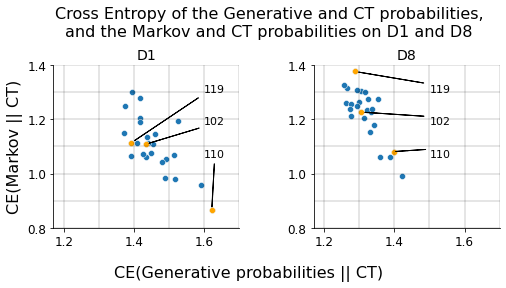

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3), facecolor = 'white')
highlighted = [119, 102, 110]


########################################################
####### D1 PLOT
########################################################

## Draw all the datapoints
sns_plot = sns.scatterplot(ax = ax[0], data = cross_entropy, x = cross_entropy.CE_gen_probs_CT[1],
                           y = cross_entropy.CE_Markov_CT[1])

## Draw the highlighted datapoints
sns_plot = sns.scatterplot(ax = ax[0], data = cross_entropy.loc[highlighted, :], 
                           x = cross_entropy.loc[highlighted, :].CE_gen_probs_CT[1],
                           y = cross_entropy.loc[highlighted, :].CE_Markov_CT[1], color = 'orange')

## Set subplot specific values
sns_plot.set_ylabel('CE(Markov || CT)', fontsize = 16)
sns_plot.set_title('D1', fontsize = 14)


## Annotate the highlighted participants
annotate(highlighted, 1)


########################################################
####### D8 PLOT
########################################################
## Draw all the datapoints
sns_plot = sns.scatterplot(ax = ax[1], data = cross_entropy, x = cross_entropy.CE_gen_probs_CT[8],
                           y = cross_entropy.CE_Markov_CT[8])
sns_plot.set_ylabel(None)


## Draw the highlighted datapoints
sns_plot = sns.scatterplot(ax = ax[1], data = cross_entropy.loc[highlighted, :], 
                           x = cross_entropy.loc[highlighted, :].CE_gen_probs_CT[8],
                           y = cross_entropy.loc[highlighted, :].CE_Markov_CT[8], color = 'orange')
sns_plot.set_ylabel(None)
sns_plot.set_title('D8',fontsize = 14)
## Annotate the highlighted participants
annotate(highlighted, 8, x_text=1.5)


for ax in fig.axes:

    ## set ticks tick labels and axis labels
    ax.set_xlim(1.17, 1.7)
    ax.set_ylim(0.8, 1.4)
    ax.set_xticks([1.2, 1.4, 1.6])
    ax.set_xticklabels([1.2, 1.4, 1.6], fontsize = 12)
    ax.set_yticks([0.8, 1, 1.2, 1.4])
    ax.set_yticklabels([0.8, 1.0, 1.2, 1.4], fontsize = 12)
    ax.set_xlabel(None)
    
    
    ##
    for y_line in np.linspace(0.8, 1.6, 9):
        ax.axhline(y = y_line, color = 'black', lw = 0.2)
        
    for x_line in np.arange(1.2, 1.8, 0.1):
        ax.axvline(x = x_line, color = 'black', lw = 0.2)
        


    
    
    
plt.subplots_adjust(wspace=0.4)
sns.despine()
plt.text(0.6, 0.62,'CE(Generative probabilities || CT)', fontsize = 16)
plt.suptitle('Cross Entropy of the Generative and CT probabilities,\nand the Markov and CT probabilities on D1 and D8',
            y = 1.15, fontsize = 16)

plt.savefig(paths.plot_save_path +'hidden_states/' + 'Cross_entropy_PlosCB_fig6gh_reproduce.png', bbox_inches='tight');

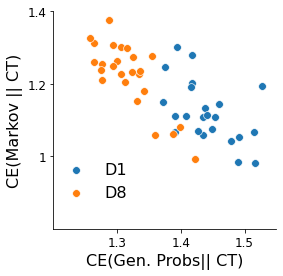

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4), facecolor = 'white')
sns_plot = sns.scatterplot(data = cross_entropy, x = cross_entropy.CE_gen_probs_CT[1],
                           y = cross_entropy.CE_Markov_CT[1], label = "D1", s= 60)

sns_plot.set_ylabel('CE(Markov || CT)', fontsize = 16)


sns_plot = sns.scatterplot(data = cross_entropy, x = cross_entropy.CE_gen_probs_CT[8],
                           y = cross_entropy.CE_Markov_CT[8], label = "D8", s= 60)

for ax in fig.axes:
    ax.set_ylim(0.8, 1.4)
    ax.set_xlim(1.2, 1.55)
    ax.set_xlabel('CE(Gen. Probs|| CT)', fontsize = 16)
    ax.set_xticks([1.3, 1.4, 1.5])
    ax.set_xticklabels([1.3, 1.4, 1.5], fontsize = 12)
    ax.set_yticks([1, 1.2, 1.4])
    ax.set_yticklabels([1, 1.2, 1.4], fontsize = 12)

    
    
sns_plot.legend(frameon = False, fontsize = 16, loc = (0.0, 0.1))

sns.despine()
plt.savefig(paths.plot_save_path +'hidden_states/' + 'Cross_entropy_Markov_CT_Gen_probs_D1_D8.png', bbox_inches='tight');

In [27]:
def get_x_jitter(df, columns, jitter = 0.05):
    
    '''
    Columns expected to be a list. 
    
    '''
    jitter = jitter
    x_jitter = pd.DataFrame(np.random.normal(loc=0,
                                             scale=jitter, 
                                             size=df.values.shape),
                                             columns=df.columns)
    # ennek a sornak az a lényege, hogy növekvő értékűvé tegye a random noise data-t. 
    # Tehát az első oszlophoz 0-t, a másidikhoz 1-et adok hozzá hozzá. 

    x_jitter[columns] += np.arange(len(columns))
    return (x_jitter[columns])

In [28]:
cross_entropy_d1_d8 = copy.deepcopy(CE_Markov_CT_d1_d8) ## this is not the most elegant way to recreate this 
## df, but for now it will suffice. 
cross_entropy_d1_d8.columns = [item[1] for item in cross_entropy_d1_d8.columns]

cross_entropy_d1_d8.reset_index(inplace = True)
x_jitter = get_x_jitter(cross_entropy_d1_d8, cross_entropy_d1_d8.columns[1:])

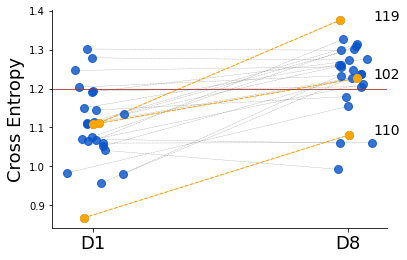

In [29]:
fig, ax = plt.subplots(1, 1, facecolor = 'white')


for col in cross_entropy_d1_d8.columns[1:]:

        
        ax.plot(x_jitter.loc[:, col], cross_entropy_d1_d8.loc[:, col], 'o', zorder=1, ms=pp.markersize_matplotlib, color = pp.basic_color, alpha = 0.8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['D1', 'D8'], fontsize = 18)
#         ax.set_xlim(-0.5,1.5)
#         ax.set_ylim(-.15,.35)
#         ax.set_yticks([0, 0.2])
#         ax.set_yticklabels([0, 0.2], fontsize = pp.ticklabsize)


for idx in cross_entropy_d1_d8.index:
    ax.plot(x_jitter.loc[idx, cross_entropy_d1_d8.columns[1:]],
            cross_entropy_d1_d8.loc[idx, cross_entropy_d1_d8.columns[1:]],
            color = 'grey', 
            linewidth = 0.3, linestyle = '--', zorder=-1)
    
    
## Plot the highlighted participants: 119, 110, 102
highlighted = cross_entropy_d1_d8.loc[cross_entropy_d1_d8['participant_test'].isin([119, 110, 102])].index

for col in cross_entropy_d1_d8.columns[1:]:
        ax.plot(x_jitter.loc[highlighted, col], cross_entropy_d1_d8.loc[highlighted, col], 'o', zorder=1, ms=pp.markersize_matplotlib, color = 'orange', alpha = 1)

        
for idx in highlighted:
    ax.plot(x_jitter.loc[idx, cross_entropy_d1_d8.columns[1:]],
            cross_entropy_d1_d8.loc[idx, cross_entropy_d1_d8.columns[1:]],
            color = 'orange', 
            linewidth = 1, linestyle = '--', zorder=-1)
    
    
for i in highlighted:
    plt.annotate(cross_entropy_d1_d8.loc[i,'participant_test'], (1.1, cross_entropy_d1_d8.loc[i, 8]), fontsize = 14)


plt.axhline(y = 1.2, color = 'brown', lw = 0.8)
plt.ylabel('Cross Entropy', fontsize = 18)


    
# plt.annotate(cross_entropy_d1_d8.loc[highlighted, :]['participant_test'], 
#              (cross_entropy_d1_d8.loc[highlighted, :][1], cross_entropy_d1_d8.loc[highlighted, :][8]))
sns.despine()
plt.savefig(paths.plot_save_path +'hidden_states/' + 'CE(Markov||CT)_D1_D8.png', bbox_inches='tight');

## Paired t-test

In [30]:
results = stats.ttest_rel(cross_entropy_d1_d8[1], cross_entropy_d1_d8[8])
print('t-value:', np.round(results.statistic, decimals = 3),
      'p-value:', np.round(results.pvalue, decimals = 3),
      'df:', results.df)

t-value: -5.743 p-value: 0.0 df: 24


## Cross entropy scatter D1 vs D8 

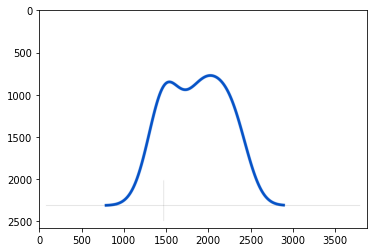

In [31]:
distplot = image.imread(paths.plot_save_path +'hidden_states/' + 'CE_distplot.png')
plt.imshow(distplot)

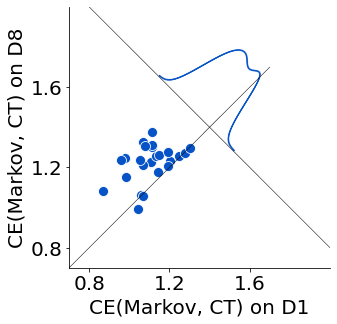

In [32]:
fig, ax = plt.subplots(1, 1, figsize = pp.figsize, facecolor = 'white')

sns_plot = sns.scatterplot(data = cross_entropy_d1_d8, x = 1, y = 8,
                           s = pp.markersize_seaborn, color = pp.basic_color)


sns_plot.set_xlabel('CE(Markov, CT) on D1', fontsize = pp.legendfontsize)
sns_plot.set_ylabel('CE(Markov, CT) on D8', fontsize = pp.legendfontsize)
sns_plot.set_xlim(0.7, 2)
sns_plot.set_ylim(0.7, 2)


ticks = np.arange(0.8, 2, 0.4)
labels = np.round(np.arange(0.8, 2, 0.4), decimals = 1)


sns_plot.set_xticks(ticks)
sns_plot.set_xticklabels(labels, fontsize = pp.ticklabsize)

sns_plot.set_yticks(ticks)
sns_plot.set_yticklabels(labels, fontsize = pp.ticklabsize)

sns.despine()


####################################
### Plot diagonal lines 
plt.plot([0, 1.7], [0, 1.7], lw = 0.5, color = 'black')
plt.plot([2.1, 0.7], [0.7, 2.1], lw = 0.5, color = 'black')


####################################
## Place the distplot as an image to the plot 
####################################

ax = plt.gca()
img=image.imread(paths.plot_save_path +'hidden_states/' + 'CE_distplot.png')
imgplot = ax.imshow(img, interpolation=None)
right, up = [1640, 8055]
transform = mpl.transforms.Affine2D().translate(right*(-1), up*(-1)).scale(0.05, 0.05).rotate_deg(135)
imgplot.set_transform(transform)


## here saving these is not the best way. THe distribution will be shown with ugly resolution because I cannot 
## manage the imported JPG's resolution. 

plt.savefig(paths.plot_save_path +'hidden_states/' + 'CE(Markov||CT)_D1_vs_D8_scatter_plus_dist.png', bbox_inches='tight')
plt.savefig(paths.plot_save_path +'hidden_states/' + 'CE(Markov||CT)_D1_vs_D8_scatter_plus_dist.pdf', bbox_inches='tight')

## Points' distance from the diagonal

https://bobbyhadz.com/blog/numpy-calculate-distance-between-point-and-line

In [33]:
cross_entropy_d1_d8.head(2)

,participant_test,1.0,8.0
0,101,1.059844,1.060899
1,102,1.108223,1.225916


In [34]:
p1 = np.array([0, 0])
p2 = np.array([5, 5])

for i in cross_entropy_d1_d8.index:
    x, y= cross_entropy_d1_d8.loc[i,[1, 8]] ## taking the x and y coords from the dataframe (x - d1, y - d8)
    xy_cords = np.array([x, y])
    distance = np.cross(p2 - p1, xy_cords - p1) / np.linalg.norm(p2 - p1)
    cross_entropy_d1_d8.loc[i, 'distance'] = distance 
#    cross_entropy_d1_d8['distance_neg'] =  cross_entropy_d1_d8['distance']*-1

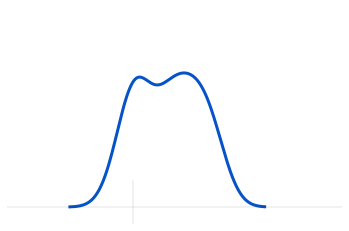

In [36]:
sns_plot = sns.kdeplot(data=cross_entropy_d1_d8, x='distance', lw = 3, color = pp.basic_color)
sns.despine(left = True, bottom = True)


sns_plot.set_xlim(-0.3, .5)
sns_plot.set_ylim(-0.5, 6)
sns_plot.set_xlabel(None)
sns_plot.set_ylabel(None);
sns_plot.set_xticks([])
sns_plot.set_yticks([]);
sns_plot.axvline(x = 0, ymin = -0.2, ymax= 0.2, color = 'black', lw = 0.1);
sns_plot.axhline(y = 0, color = 'black', lw = 0.1);

plt.savefig(paths.plot_save_path +'hidden_states/'  + 'CE_distplot.png', bbox_inches='tight', dpi = 800)
plt.savefig(paths.plot_save_path +'hidden_states/'  + 'CE_distplot.svg', bbox_inches='tight')